In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [269]:
import pygame
actions = ['up','down','left','right','Rotate clockwise','Rotate counter-clockwise','shoot']
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        # Define action and observation spaces
        self.grid_size = 1024
        self.grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8)
        self.action_space = spaces.Discrete(7) 

        self.laction1 = -1
        self.laction2 = -1
        # Initialize agent positions and orientations
        self.agent1_pos = [512, 512]  # Initial position of agent 1
        self.agent2_pos = [256, 256]  # Initial position of agent 2
        self.agent1_facing = 90 
        self.agent2_facing = 270

        self.agent_size = 20

        self.reward1 = 0
        self.reward2 = 0

        #self.fig, self.ax = plt.subplots()
        #self.im = self.ax.imshow(self.grid)
        #self.screen = pygame.display.set_mode((800, 600))
        #pygame.display.set_caption("Custom Environment")

    def get_direction(self,agentAttacking,agentDefending):
        x_diff = agentDefending[0] - agentAttacking[0]
        y_diff = agentDefending[1] - agentAttacking[1]
        return math.degrees(math.atan2(y_diff, x_diff))

    def step(self, action1, action2):
        self.laction1 = action1
        self.laction2 = action2
        self.reward1 -= 1
        self.reward2 -= 1
        if action1 == 0:  # Move up
            self.agent1_pos[1] -= 1
        elif action1 == 1:  # Move down
            self.agent1_pos[1] += 1
        elif action1 == 2:  # Move left
            self.agent1_pos[0] -= 1
        elif action1 == 3:  # Move right
            self.agent1_pos[0] += 1
        elif action1 == 4:  # Rotate clockwise
            self.agent1_facing += 10
        elif action1 == 5:  # Rotate counter-clockwise
            self.agent1_facing -= 10
        elif action1 == 6:  # Shoot
            diff = self.agent1_facing - self.get_direction(self.agent1_pos,self.agent2_pos)
            if self.distance(self.agent2_pos,self.agent1_pos) < 500:
                if diff== 0:
                    self.reward1 += 400
                    self.reward2 -= 10
                else:
                    if diff<45:
                        self.reward1 += 360/abs(diff)
                        self.reward2 -= 10
                    else:
                        self.reward1 -= 10
            else:
                        self.reward1 -= 10


        if action2 == 0:  # Move up
            self.agent2_pos[1] -= 1
        elif action2 == 1:  # Move down
            self.agent2_pos[1] += 1
        elif action2 == 2:  # Move left
            self.agent2_pos[0] -= 1
        elif action2 == 3:  # Move right
            self.agent2_pos[0] += 1
        elif action2 == 4:  # Rotate clockwise
            self.agent2_facing += 10
        elif action2 == 5:  # Rotate counter-clockwise
            self.agent2_facing -= 10
        elif action2 == 6:  # Shoot
            diff = self.agent2_facing - self.get_direction(self.agent2_pos,self.agent1_pos)
            if self.distance(self.agent2_pos,self.agent1_pos) < 500:
                if diff== 0:
                    self.reward2 += 400
                    self.reward1 -= 10
                else:
                    if diff<45:
                        self.reward2 += 360/abs(diff)
                        self.reward1 -= 10
                    else:
                        self.reward2 -= 10
            else:
                        self.reward2 -= 10

        self.agent1_pos[0] = max(0, min(self.agent1_pos[0], 1023))
        self.agent1_pos[1] = max(0, min(self.agent1_pos[1], 1023))
        self.agent2_pos[0] = max(0, min(self.agent2_pos[0], 1023))
        self.agent2_pos[1] = max(0, min(self.agent2_pos[1], 1023))

        observation1 = self._get_observation1()
        observation2 = self._get_observation2()
        done = self.reward1 >= 1000 or self.reward2 >= 1000

        return observation1 , observation2, self.reward1, self.reward2, done, {}
    def _get_grid(self):
        self.grid.fill(0)

        # Draw agents on the grid
        self.grid[self.agent1_pos[1] - self.agent_size // 2:self.agent1_pos[1] + self.agent_size // 2,
                  self.agent1_pos[0] - self.agent_size // 2:self.agent1_pos[0] + self.agent_size // 2] = [255, 0, 0]  # Agent 1 (red)
        self.grid[self.agent2_pos[1] - self.agent_size // 2:self.agent2_pos[1] + self.agent_size // 2,
                  self.agent2_pos[0] - self.agent_size // 2:self.agent2_pos[0] + self.agent_size // 2] = [0, 0, 255]  # Agent 2 (blue)

        return self.grid
    def distance(self, pos1, pos2):
        # Calculate Euclidean distance between pos1 and pos2
        return math.sqrt((pos2[0] - pos1[0]) ** 2 + (pos2[1] - pos1[1]) ** 2)
    def _get_observation1(self):
        # Calculate direction and distance between agents
        direction = self.agent1_facing - self.get_direction(self.agent1_pos,self.agent2_pos)
        distance = int(self.distance(self.agent1_pos, self.agent2_pos))
        return direction, distance
    def _get_observation2(self):
        # Calculate direction and distance between agents
        direction = self.agent2_facing - self.get_direction(self.agent2_pos,self.agent1_pos)
        distance = int(self.distance(self.agent2_pos, self.agent1_pos))
        return direction, distance
    def reset(self):
        self.agent1_pos = [768, 512] 
        self.agent2_pos = [256, 512]  
        self.agent1_facing = 180
        self.agent2_facing = 0 
        self.reward1 = 0
        self.reward2 = 0
        return self._get_observation1(), self._get_observation2()
    def render(self, mode='human'):
        # Visualize the environment
        self.screen.fill((255, 255, 255))
        for i in range(1024):
            for j in range(1024):
                pygame.draw.rect(self.screen, (200, 200, 200), (i * 2, j * 2, 2, 2))
        a1 = self.agent1_pos
        a2 = self.agent2_pos
        a1f = self.agent1_facing
        a2f = self.agent2_facing
        a1_endpoint_x = a1[0] + np.cos(a1f) * 5
        a1_endpoint_y = a1[1] + np.sin(a1f) * 5
        a2_endpoint_x = a2[0] + np.cos(a2f) * 5
        a2_endpoint_y = a2[1] + np.sin(a2f) * 5
        pygame.draw.circle(self.screen, (255, 0, 0), (a1[0] * 2, a1[1] * 2), 4)
        pygame.draw.circle(self.screen, (0, 0, 255), (a2[0] * 2, a2[1] * 2), 4)
        pygame.draw.line(self.screen, (0, 0, 255), (a1[0] * 2, a1[1]), (int(a1_endpoint_x) * 2, int(a1_endpoint_y) * 2), 2)
        pygame.draw.line(self.screen, (0, 0, 255), (a2[0] * 2, a2[1]), (int(a2_endpoint_x) * 2, int(a2_endpoint_y) * 2), 2)
        pygame.display.flip() 

        

In [258]:
env = CustomEnv()


# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.9  # Epsilon for epsilon-greedy policy
ce = 0.9
num_episodes = 1000  # Number of episodes
max_steps_per_episode = 1000  # Maximum number of steps per episode



# Initialize Q-table
action_space_size = env.action_space.n
output_size = env.action_space.n

model1 = DQN(2, output_size).to(device)
model2 = DQN(2, output_size).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=alpha)
optimizer2 = optim.Adam(model2.parameters(), lr=alpha)
loss_fn = nn.MSELoss()


# Q-learning algorithm
for episode in range(num_episodes):
    state1,state2 = env.reset()
    ce = epsilon-episode/10000*0.99
    total_reward1 = 0
    total_reward2 = 0
    for step in range(max_steps_per_episode):
        state1_tensor = torch.tensor(state1, dtype=torch.float32).to(device)
        state2_tensor = torch.tensor(state2, dtype=torch.float32).to(device)
        # Choose action
        if np.random.uniform(0, 1) < ce:
            action1 = env.action_space.sample()  # Explore action space
        else:
            q_values1 = model1(state1_tensor.unsqueeze(0)) 
            action1 = torch.argmax(q_values1).item()
        if np.random.uniform(0, 1) < ce:
            action2 = env.action_space.sample()  # Explore action space
        else:
            q_values2 = model2(state2_tensor.unsqueeze(0)) 
            action2 = torch.argmax(q_values2).item()
        
        # Take action
        next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                               )
        
        # Update Q-value
        q_values1_next = model1(torch.tensor(next_state1, dtype=torch.float32).to(device).unsqueeze(0))
        q_values2_next = model2(torch.tensor(next_state2, dtype=torch.float32).to(device).unsqueeze(0))
        target1 = reward1 + gamma * torch.max(q_values1_next)
        target2 = reward2 + gamma * torch.max(q_values2_next)
        q_values1_target = model1(state1_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values2_target = model2(state2_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values1_target[action1] = target1
        q_values2_target[action2] = target2
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss1 = loss_fn(model1(state1_tensor.unsqueeze(0)), q_values1_target.unsqueeze(0))
        loss2 = loss_fn(model2(state2_tensor.unsqueeze(0)), q_values2_target.unsqueeze(0))
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()

        total_reward1 += reward1
        total_reward2 += reward2
        state1 = next_state1
        state2 = next_state2
        

        if done:
            break
    
    print(f"Episode: {episode,step}, Total Reward: {total_reward1,total_reward2}")


KeyboardInterrupt: 

In [253]:
next_state1

(0.0, 508)

In [249]:
state1,state2 = env.reset()

In [224]:
a1 = env.agent1_pos
a2 = env.agent2_pos
a1,a2

([748, 512], [0, 512])

In [247]:
action1 = 6
action2 = 4
next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                               )
        
# Update Q-value
q_values1_next = model1(torch.tensor(next_state1, dtype=torch.float32).to(device).unsqueeze(0))
q_values2_next = model2(torch.tensor(next_state2, dtype=torch.float32).to(device).unsqueeze(0))
target1 = reward1 + gamma * torch.max(q_values1_next)
target2 = reward2 + gamma * torch.max(q_values2_next)
q_values1_target = model1(state1_tensor.unsqueeze(0)).squeeze(0).to(device)
q_values2_target = model2(state2_tensor.unsqueeze(0)).squeeze(0).to(device)
q_values1_target[action1] = target1
q_values2_target[action2] = target2

optimizer1.zero_grad()
optimizer2.zero_grad()
loss1 = loss_fn(model1(state1_tensor.unsqueeze(0)), q_values1_target.unsqueeze(0))
loss2 = loss_fn(model2(state2_tensor.unsqueeze(0)), q_values2_target.unsqueeze(0))
loss1.backward()
loss2.backward()
optimizer1.step()
optimizer2.step()

total_reward1 += reward1
total_reward2 += reward2
state1 = next_state1
state2 = next_state2
print(f"Episode: {episode,step}, Total Reward: {reward1,reward2}")

Episode: (29, 4), Total Reward: (-40, 0)


In [271]:
env = CustomEnv()
for episode in range(num_episodes):
    state1,state2 = env.reset()
    ce = 0
    total_reward1 = 0
    total_reward2 = 0
    for step in range(max_steps_per_episode):
        state1_tensor = torch.tensor(state1, dtype=torch.float32).to(device)
        state2_tensor = torch.tensor(state2, dtype=torch.float32).to(device)
        # Choose action
        if np.random.uniform(0, 1) < ce:
            action1 = env.action_space.sample()  # Explore action space
        else:
            q_values1 = model1(state1_tensor.unsqueeze(0)) 
            action1 = torch.argmax(q_values1).item()
        if np.random.uniform(0, 1) < ce:
            action2 = env.action_space.sample()  # Explore action space
        else:
            q_values2 = model2(state2_tensor.unsqueeze(0)) 
            action2 = torch.argmax(q_values2).item()
        
        # Take action
        next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                               )
        
        # Update Q-value
        q_values1_next = model1(torch.tensor(next_state1, dtype=torch.float32).to(device).unsqueeze(0))
        q_values2_next = model2(torch.tensor(next_state2, dtype=torch.float32).to(device).unsqueeze(0))
        target1 = reward1 + gamma * torch.max(q_values1_next)
        target2 = reward2 + gamma * torch.max(q_values2_next)
        q_values1_target = model1(state1_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values2_target = model2(state2_tensor.unsqueeze(0)).squeeze(0).to(device)
        q_values1_target[action1] = target1
        q_values2_target[action2] = target2
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss1 = loss_fn(model1(state1_tensor.unsqueeze(0)), q_values1_target.unsqueeze(0))
        loss2 = loss_fn(model2(state2_tensor.unsqueeze(0)), q_values2_target.unsqueeze(0))
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()

        total_reward1 += reward1
        total_reward2 += reward2
        state1 = next_state1
        state2 = next_state2
        

        if done:
            break
    
    print(f"Episode: {episode,step}, Total Reward: {total_reward1,total_reward2}")

Episode: (0, 57), Total Reward: (-12091, -1811)
Episode: (1, 65), Total Reward: (-17301, -2311)
Episode: (2, 65), Total Reward: (-17431, -2311)
Episode: (3, 72), Total Reward: (-20021, -2851)
Episode: (4, 75), Total Reward: (-22216, -3076)
Episode: (5, 999), Total Reward: (-1355035.9910222257, -772370)
Episode: (6, 999), Total Reward: (-1212460, -513810)
Episode: (7, 999), Total Reward: (-805170, -657400)
Episode: (8, 999), Total Reward: (-947080, -978610)
Episode: (9, 999), Total Reward: (-982150, -500500)
Episode: (10, 999), Total Reward: (-1117470, -500750)
Episode: (11, 999), Total Reward: (-1342560, -500500)
Episode: (12, 999), Total Reward: (-1009960, -500500)
Episode: (13, 999), Total Reward: (-509130, -500500)
Episode: (14, 999), Total Reward: (-1030540, -500500)
Episode: (15, 999), Total Reward: (-1101570, -500500)
Episode: (16, 999), Total Reward: (-1056940, -500500)
Episode: (17, 999), Total Reward: (-1442040, -2903750)
Episode: (18, 15), Total Reward: (964, -196)
Episode: (

KeyboardInterrupt: 

In [272]:
import cv2
video_writer = cv2.VideoWriter('environment_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
                                            (1024, 1024))


In [273]:
import time
screen = pygame.display.set_mode((1024, 1024))
ac1 = ""
ac2 = ""
def render(a1, a2, a1f, a2f,ac1,ac2):
    screen.fill((255, 255, 255))
    a1_endpoint_x = a1[0] + np.cos(np.deg2rad(a1f)) * 8
    a1_endpoint_y = a1[1] + np.sin(np.deg2rad(a1f)) * 8
    a2_endpoint_x = a2[0] + np.cos(np.deg2rad(a2f)) * 8
    a2_endpoint_y = a2[1] + np.sin(np.deg2rad(a2f)) * 8
    if(ac1 == "shoot"):
        c1 = (255,255,0)
    else:
        c1 = (255,0,0)
    if(ac2 == "shoot"):
        c2 = (0,255,255)
    else:
        c2 = (0, 0, 255)
    pygame.draw.circle(screen, c1, (a1[0], a1[1]), 6)
    pygame.draw.circle(screen, c2, (a2[0], a2[1]), 6)
    pygame.draw.line(screen, (0, 0, 255), (a1[0], a1[1]), (int(a1_endpoint_x), int(a1_endpoint_y)), 2)
    pygame.draw.line(screen, (255, 0, 0), (a2[0], a2[1]), (int(a2_endpoint_x), int(a2_endpoint_y)), 2)
    pygame.display.flip() 
    screen_surface = pygame.display.get_surface()
    screen_data = pygame.image.tostring(screen_surface, 'RGB')
    frame = np.fromstring(screen_data, dtype=np.uint8, sep='')
    frame = frame.reshape((1024,1024, 3))
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video_writer.write(frame)
    return
state1,state2 = env.reset()
for step in range(1000):
    a1 = env.agent1_pos
    a2 = env.agent2_pos
    a1f = env.agent1_facing
    a2f = env.agent2_facing
    render(a1, a2, a1f, a2f,ac1,ac2)
    state1_tensor = torch.tensor(state1, dtype=torch.float32).to(device)
    state2_tensor = torch.tensor(state2, dtype=torch.float32).to(device)
    # Choose action
    q_values1 = model1(state1_tensor.unsqueeze(0)) 
    action1 = torch.argmax(q_values1).item()
    q_values2 = model2(state2_tensor.unsqueeze(0))
    action2 = torch.argmax(q_values2).item()
        
    ac1 = actions[action1]
    ac2 = actions[action2]
    # Take action
    next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                            )
    
    total_reward1 += reward1
    total_reward2 += reward2
    state1 = next_state1
    state2 = next_state2
video_writer.release()
print(f"Reward: {total_reward1,total_reward2}")

C:\Users\wang3\AppData\Local\Temp\ipykernel_34452\2443340406.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frame = np.fromstring(screen_data, dtype=np.uint8, sep='')


Reward: (145481175, -4183235)


In [25]:
pygame.quit()

In [ ]:
def visualize_q_map(model):
    direction_values = list(range(360))
    distance_values = list(range(1024))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan']
    fig = plt.figure(dpi=200,figsize=(8, 8))
    ax = fig.add_subplot(projection='polar')
    for direction in direction_values:
        radians = np.deg2rad(direction)
        for distance in distance_values:
            state = [direction, distance]
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = model(state_tensor.unsqueeze(0))
            action = torch.argmax(q_values).item()            
            plt.polar(radians, distance,marker=',', color=colors[action])

    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location("N")  # Set zero degrees at the top
    plt.title('Polar Distance vs. Degree by Actions')
    plt.show()

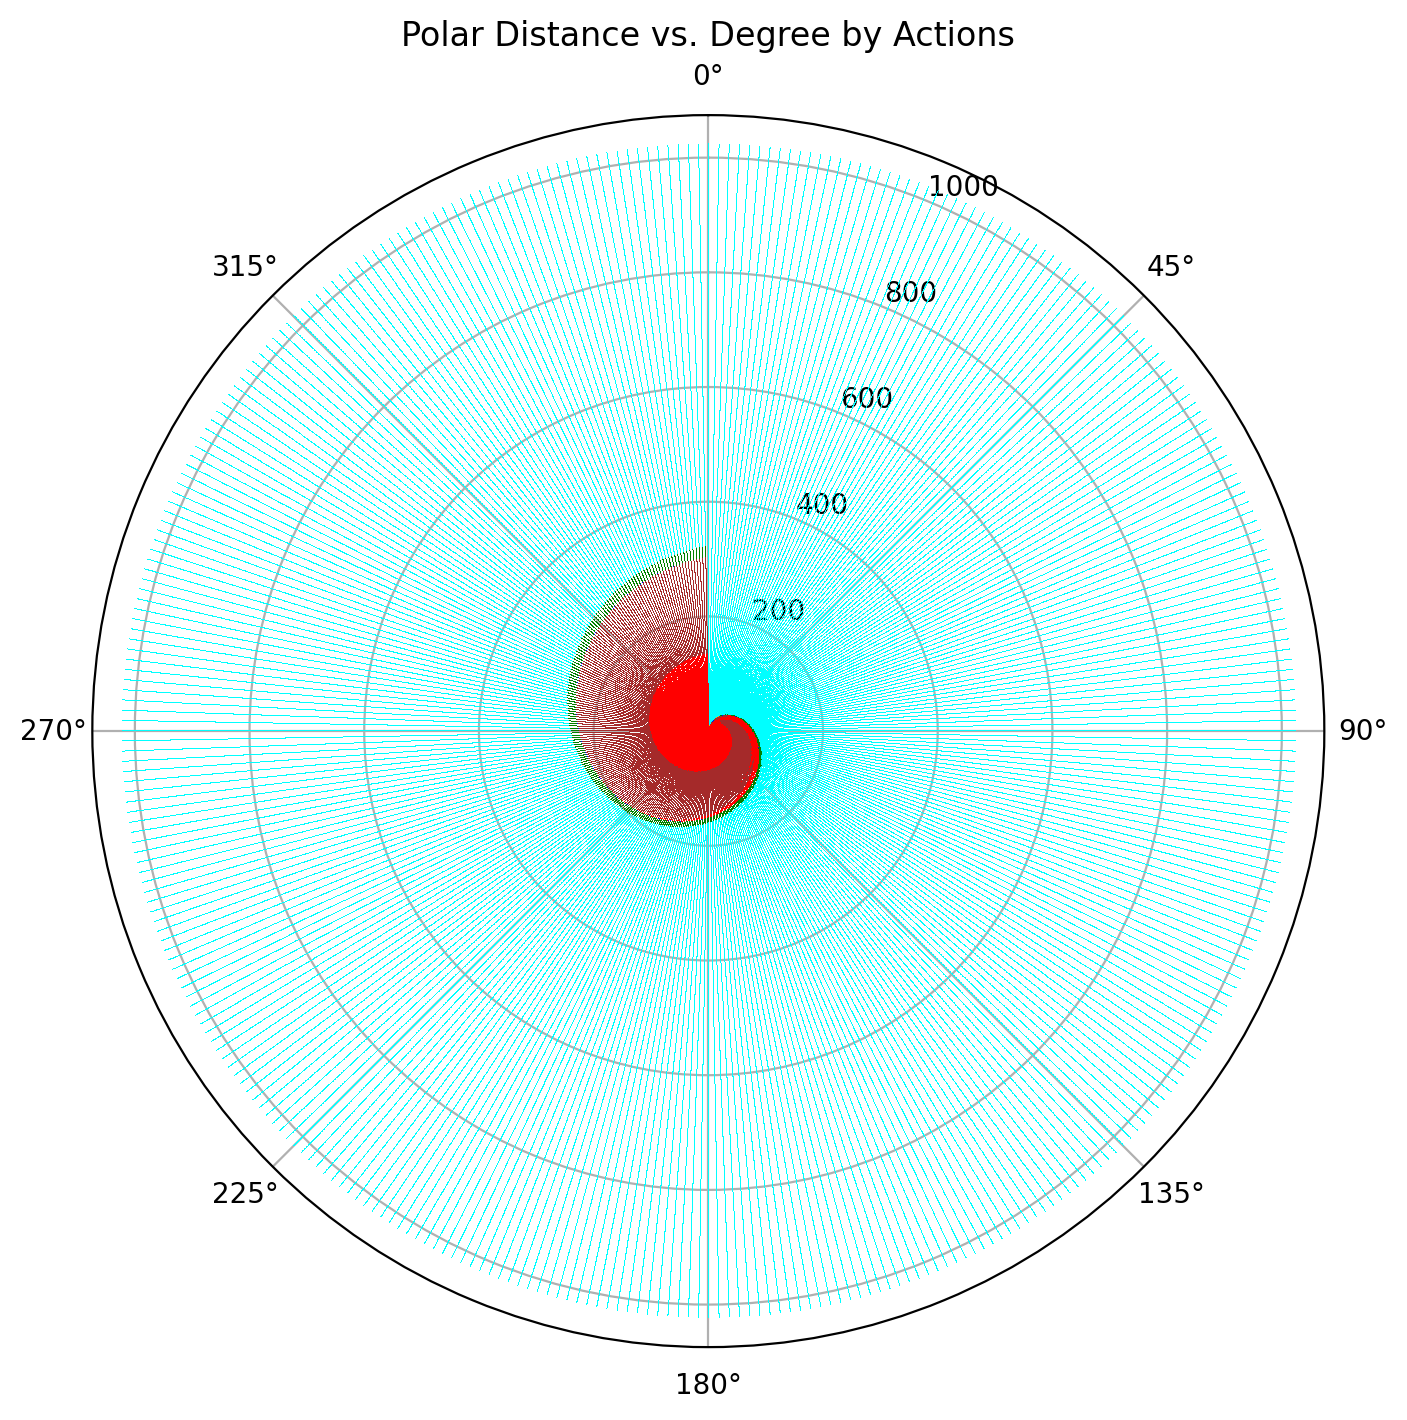

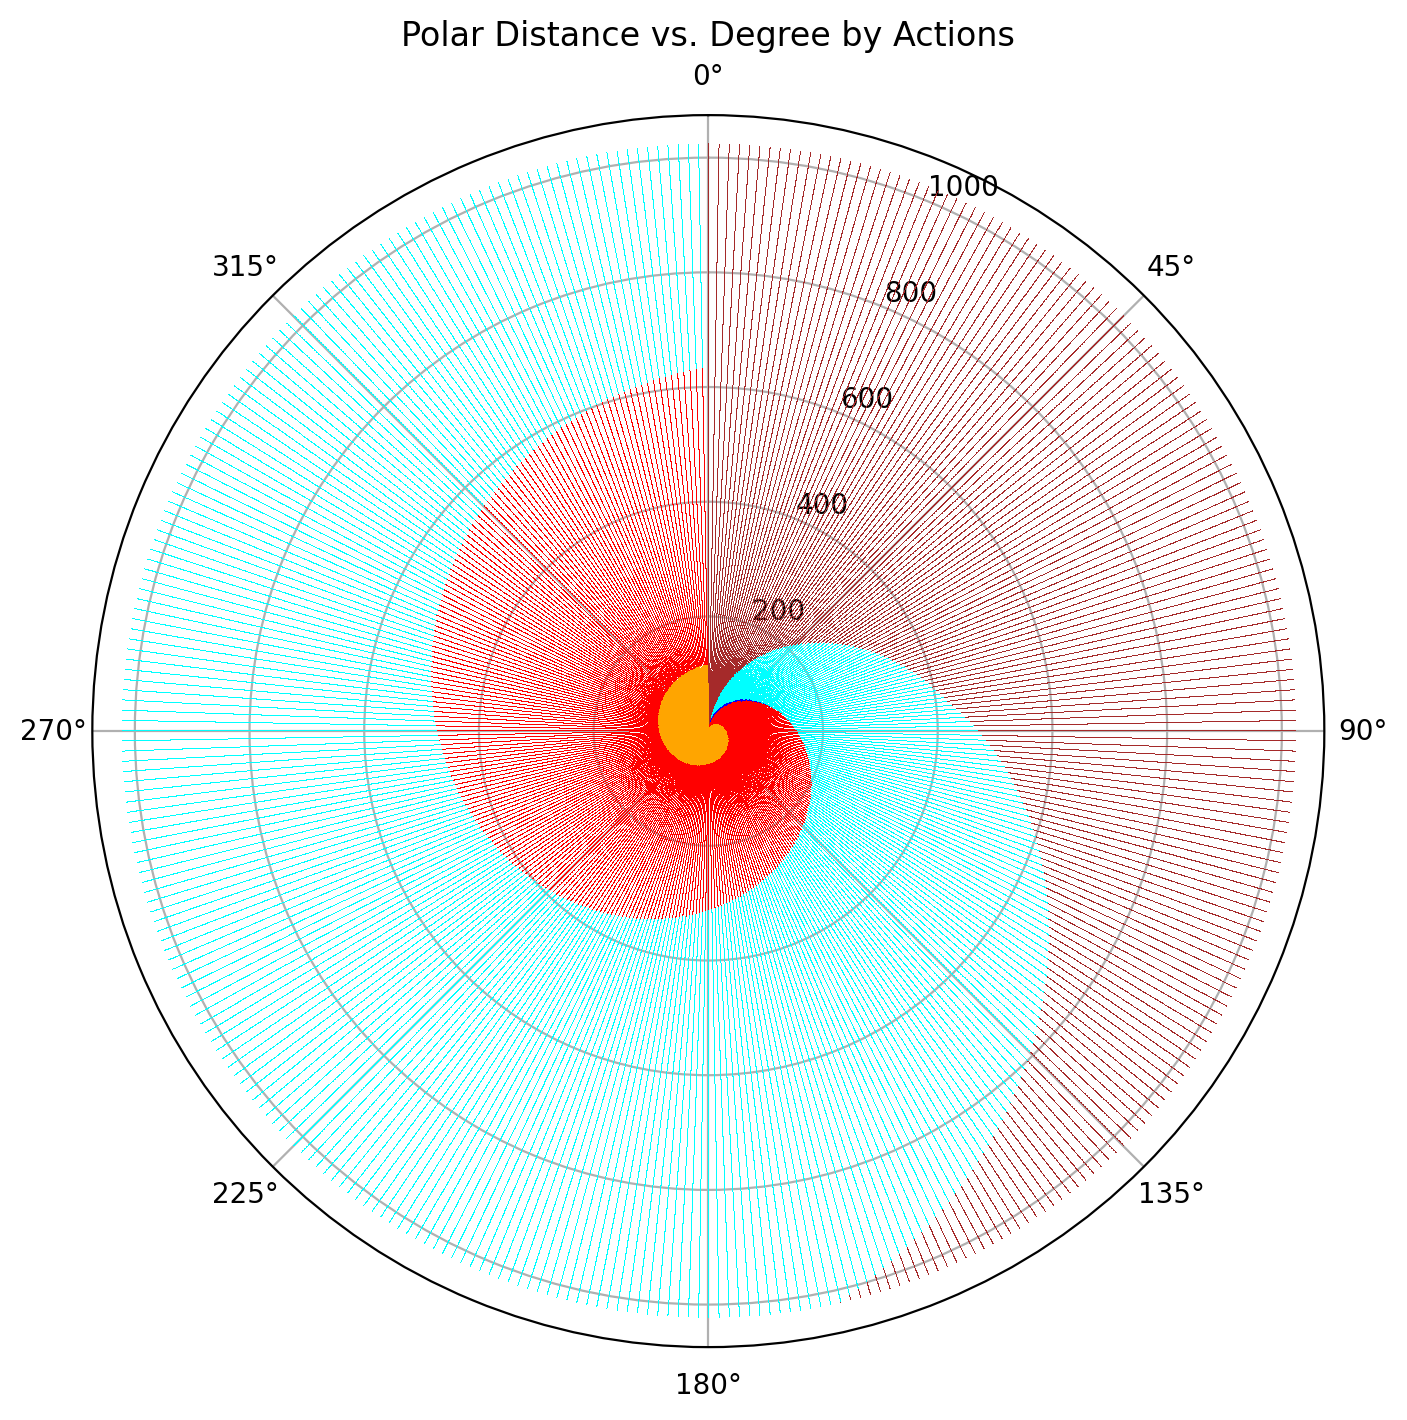

In [ ]:
visualize_q_map(model1)
visualize_q_map(model2)